In [1]:
import sys

sys.path.append("../")

In [2]:
import requests
import time
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from stats_arb.tests import adf_test, kpss_test, cal_half_life, pp_test
from datetime import datetime, timedelta
from ta.volatility import BollingerBands

import matplotlib.pyplot as plt


In [3]:
API_BASE = 'https://fapi.binance.com/fapi/v1/'
TIMEFRAME = '1h'

LABELS = [
    'open_time',
    'open',
    'high',
    'low',
    'close',
    'volume',
    'close_time',
    'quote_asset_volume',
    'number_of_trades',
    'taker_buy_base_asset_volume',
    'taker_buy_quote_asset_volume',
    'ignore'
]

DROP_COLUMNS=[
    'close_time',
    'quote_asset_volume',
    'number_of_trades',
    'taker_buy_base_asset_volume',
    'taker_buy_quote_asset_volume',
    'ignore'
]


def get_batch(symbol, interval='1m', start_time=0, limit=1000):
    """Use a GET request to retrieve a batch of candlesticks. Process the JSON into a pandas
    dataframe and return it. If not successful, return an empty dataframe.
    """

    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_time,
        'limit': limit
    }
    try:
        # timeout should also be given as a parameter to the function
        response = requests.get(f'{API_BASE}klines', params, timeout=30)
    except requests.exceptions.ConnectionError:
        print('Connection error, Cooling down for 5 mins...')
        time.sleep(5 * 60)
        return get_batch(symbol, interval, start_time, limit)

    except requests.exceptions.Timeout:
        print('Timeout, Cooling down for 5 min...')
        time.sleep(5 * 60)
        return get_batch(symbol, interval, start_time, limit)

    if response.status_code == 200:
        return pd.DataFrame(response.json(), columns=LABELS)
    
    print(f'Got erroneous response back {symbol}: {response}. {response.text}')
    return pd.DataFrame([])


def get_candles(base, quote, start_date: datetime, interval='1m'):
    batches = []

    last_timestamp = int(start_date.timestamp()) * 1000
    # gather all candlesticks available, starting from the last timestamp loaded from disk or 0
    # stop if the timestamp that comes back from the api is the same as the last one
    previous_timestamp = None

    while previous_timestamp != last_timestamp:
        # stop if we reached data from today
        if datetime.fromtimestamp(last_timestamp / 1000) >= datetime.utcnow():
            break

        previous_timestamp = last_timestamp

        new_batch = get_batch(
            symbol=base + quote,
            interval=interval,
            start_time=last_timestamp
        )

        # requesting candles from the future returns empty
        # also stop in case response code was not 200
        if new_batch.empty:
            break

        last_timestamp = new_batch['open_time'].max()

        # sometimes no new trades took place yet on date.today();
        # in this case the batch is nothing new
        if previous_timestamp == last_timestamp:
            break

        batches.append(new_batch)
        last_datetime = datetime.fromtimestamp(last_timestamp / 1000)

        covering_spaces = 20 * ' '
        print(datetime.now(), base, quote, interval, str(last_datetime) + covering_spaces, end='\r', flush=True)

    if len(batches) > 0:
        # write clean version of csv to parquet
        df = pd.concat(batches, ignore_index=True)
        df.drop(columns=DROP_COLUMNS, inplace=True)
        df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
        return df



In [4]:
# symbols = pd.read_csv(f'{DATA_PATH}/../symbols.csv')['symbol'].values.tolist()
symbols = ['BTC', 'ETH', 'BNB', 'XRP', 'ADA', 'SOL', 
        'LUNA', 'AVAX', 'DOT', 'DOGE', 'MATIC', 
        'ATOM', 'LTC', 'LINK', 'NEAR', 'ATOM', 'ALGO']
# symbols = [f'{s}USDT' for s in symbols]

data = []

for symbol in symbols:
    df = get_candles(base=symbol, quote='USDT', start_date=datetime.now() - timedelta(days=60), interval=TIMEFRAME)
    if df is None:
        continue

    df.rename(columns={'close': symbol}, inplace=True)
    # the data is too long, just limit to recent period
    log = np.log(df[symbol].astype(np.float32))
    data.append(log)

df = pd.concat(data, axis=1)
df = df.dropna(axis=1, how='all')
# df.dropna(inplace=True, how='any')

df.head()

,BTC,ETH,BNB,XRP,ADA,SOL,AVAX,DOT,DOGE,MATIC,ATOM,LTC,LINK,NEAR,ATOM,ALGO
0,10.281225,7.576927,5.686806,-0.894040,-0.659132,3.923358,3.393501,2.270888,-2.472425,-0.452714,2.324934,4.210052,1.930651,1.770025,2.324934,-0.818030
1,10.277916,7.574158,5.685517,-0.894285,-0.670212,3.924347,3.381675,2.258947,-2.475986,-0.458391,2.322976,4.203349,1.925416,1.767979,2.322976,-0.819618
2,10.276856,7.573624,5.686873,-0.914792,-0.681416,3.919991,3.358986,2.254025,-2.477415,-0.466012,2.311941,4.205737,1.920592,1.750937,2.311941,-0.830572
3,10.285582,7.583252,5.703216,-0.896488,-0.649896,3.953165,3.395514,2.287370,-2.464046,-0.439280,2.341132,4.227709,1.939748,1.783055,2.341132,-0.808783
4,10.281304,7.576154,5.699306,-0.904362,-0.663394,3.932806,3.381335,2.273568,-2.471359,-0.458391,2.323955,4.214347,1.921325,1.766613,2.323955,-0.823028


In [5]:
# df.tail()

In [6]:
p = 1
COINTEGRATION_CONFIDENCE_LEVEL = 90

# the 90%, 95%, and 99% confidence levels for the trace statistic and maximum 
# eigenvalue statistic are stored in the first, second, and third column of 
# cvt and cvm, respectively
confidence_level_cols = {
    90: 0,
    95: 1,
    99: 2
}
confidence_level_col = confidence_level_cols[COINTEGRATION_CONFIDENCE_LEVEL]


def test_johansen(symbol_pairs):
    df_t = df[symbol_pairs].copy()
    df_t.dropna(inplace=True)

    # The second and third parameters indicate constant term, with a lag of 1. 
    result = coint_johansen(df_t, 0, p)

    trace_crit_value = result.cvt[:, confidence_level_col]
    eigen_crit_value = result.cvm[:, confidence_level_col]
#     print("trace_crit_value",trace_crit_value)
#     print("eigen_crit_value",eigen_crit_value)
#     print("lr1",result.lr1)
#     print("lr2",result.lr2)

    # The trace statistic and maximum eigenvalue statistic are stored in lr1 and lr2;
    # see if they exceeded the confidence threshold
    if np.all(result.lr1 >= trace_crit_value) and np.all(result.lr2 >= eigen_crit_value):
        # print(f"{symbol_pairs} are cointegrated")
        # The first i.e. leftmost column of eigenvectors matrix, result.evec, contains the best weights.
        v1= result.evec[:,0:1]
        hr=v1/-v1[1] #to get the hedge ratio divide the best_eigenvector by the negative of the second component of best_eigenvector
        #the regression will be: close of symbList[1] = hr[0]*close of symbList[0] + error
        #where the beta of the regression is hr[0], also known as the hedge ratio, and
        #the error of the regression is the mean reverting residual signal that you need to predict, it is also known as the "spread"
        #the spread = close of symbList[1] - hr[0]*close of symbList[0] or alternatively (the same thing):
        #do a regression with close of symbList[0] as x and lose of symbList[1] as y, and take the residuals of the regression to be the spread.
        coint_pair = dict(hedge_ratio=v1[:, 0])
        for i, s in enumerate(symbol_pairs):
            coint_pair[f'sid_{i+1}'] = s

        cointegrating_pairs.append(coint_pair)



In [7]:

import itertools as it

nb_symbols = 2
cointegrating_pairs = []

#get symbol pairs
pairs = list(it.combinations(symbols, nb_symbols))

for pair in pairs:
    try:
        test_johansen(list(pair))
    except Exception:
        pass

coint_df = pd.DataFrame(cointegrating_pairs)
coint_df.head()

,hedge_ratio,sid_1,sid_2
0,"[2.266759101361126, -8.177767973395603]",BTC,SOL
1,"[6.397979634569486, -8.960025131088848]",BTC,AVAX
2,"[6.7402028747259575, -12.810307772575303]",BTC,DOGE
3,"[4.827356635394026, -11.8035262206303]",BTC,LTC
4,"[15.173229711842298, -13.291913999516678]",BTC,NEAR


In [8]:
coint_df.to_csv('coint_df.csv')


In [9]:
def calculate_spread(df, selected_row, hedge_ratio):
    spread = None
    for i in range(nb_symbols):
        if spread is None:
            spread = df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
        else:
            spread += df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
    
    spread.dropna(inplace=True)
    return spread


critical_val = 0.005

def find_stationary_portfolio():
    data = []
    for i, _ in coint_df.iterrows():
        try:
            hedge_ratio = coint_df.iloc[i]['hedge_ratio']
            _df = df.copy()
            spread = calculate_spread(_df, i, hedge_ratio)
                
            half_life = cal_half_life(spread)
            pairs_name = coint_df[[col for col in coint_df.columns if col != 'hedge_ratio']].iloc[i].values
            # print(i, pairs_name, 'is stationary with half life', half_life)
            # print(' ')
            data.append({
                'i': i,
                'pairs': pairs_name,
                'half_life': half_life
            })
        except:
            pass
    
    return pd.DataFrame(data)


stationary_df = find_stationary_portfolio()
if len(stationary_df) > 0:
    stationary_df.sort_values(by=['half_life'], inplace=True)

/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [10]:
stationary_df

,i,pairs,half_life
16,16,"[XRP, ALGO]",18
9,9,"[ETH, ALGO]",31
14,14,"[XRP, AVAX]",35
17,17,"[ADA, LINK]",38
13,13,"[BNB, ALGO]",44
5,5,"[BTC, ALGO]",48
15,15,"[XRP, LTC]",50
11,11,"[BNB, AVAX]",55
7,7,"[ETH, AVAX]",67
4,4,"[BTC, NEAR]",80


In [11]:
selected_row = stationary_df[stationary_df['i'] == 5]['i'].iloc[-1]
hedge_ratio = coint_df.iloc[selected_row]['hedge_ratio']
print(selected_row, hedge_ratio)
spread = calculate_spread(df, selected_row, hedge_ratio)
# spread = spread.iloc[-1000:]

5 [ 10.13324013 -18.58357157]


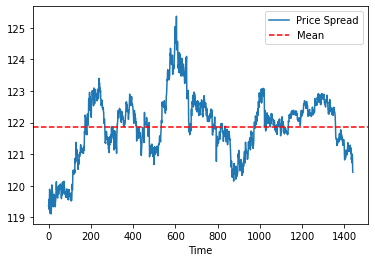

In [12]:
spread.plot() # Plot the spread
plt.axhline(spread.mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])

In [13]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

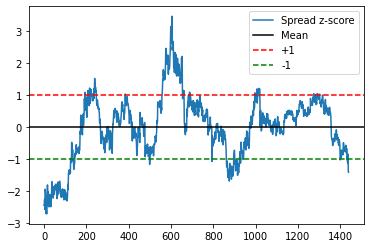

In [14]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1'])